In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
PRINT_EVERY = 5000
PLOT_EVERY = 100

language = 'ta'

In [3]:
# Language Model
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "<", EOS_token: ">"}
        self.n_chars = 2  # Count SOS and EOS

    def addWord(self, word):
        for char in str(word):
            self.addChar(char)

    def addChar(self, char):
        if char not in self.word2index:
            self.word2index[char] = self.n_chars
            self.word2count[char] = 1
            self.index2word[self.n_chars] = char
            self.n_chars += 1
        else:
            self.word2count[char] += 1

In [4]:
def get_data(lang: str, type: str) -> list[list[str]]:
    """
    Returns: 'pairs': list of [input_word, target_word] pairs
    """
    path = f"../data/dakshina_dataset_v1.0/{lang}/lexicons/{lang}.translit.sampled.{type}.tsv"
    df = pd.read_csv(path, sep='\t', header=None)
    pairs = df.values.tolist()
    return pairs

In [5]:
def get_languages(lang: str):
    """
    Returns 
    1. input_lang: input language - English
    2. output_lang: output language - Given language
    3. pairs: list of [input_word, target_word] pairs
    """
    input_lang = Language('eng')
    output_lang = Language(lang)
    pairs = get_data(lang, 'train')
    for pair in pairs:
        input_lang.addWord(pair[1])
        output_lang.addWord(pair[0])
    return input_lang, output_lang, pairs

In [6]:
def get_cell(cell_type: str):
    if cell_type == "LSTM":
        return nn.LSTM
    elif cell_type == "GRU":
        return nn.GRU
    elif cell_type == "RNN":
        return nn.RNN
    else:
        raise Exception("Invalid cell type")
    
def get_optimizer(optimizer: str):
    if optimizer == "SGD":
        return optim.SGD
    elif optimizer == "ADAM":
        return optim.Adam
    else:
        raise Exception("Invalid optimizer")

In [7]:
def indexesFromWord(lang:Language, word:str):
    return [lang.word2index[char] for char in str(word)]

def tensorFromWord(lang:Language, word:str):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(input_lang:Language, output_lang:Language, pair:list[str]):
    input_tensor = tensorFromWord(input_lang, pair[1])
    target_tensor = tensorFromWord(output_lang, pair[0])
    return (input_tensor, target_tensor)

In [8]:
class Encoder(nn.Module):
    def __init__(self,
                 in_sz: int,
                 embed_sz: int,
                 hidden_sz: int,
                 cell_type: str,
                 n_layers: int,
                 dropout: float):
        
        super(Encoder, self).__init__()
        self.hidden_sz = hidden_sz
        self.n_layers = n_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.embedding = nn.Embedding(in_sz, embed_sz)

        self.rnn = get_cell(cell_type)(input_size = embed_sz,
                                       hidden_size = hidden_sz,
                                       num_layers = n_layers,
                                       dropout = dropout)
        
    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)

        if(self.cell_type == "LSTM"):
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, hidden = self.rnn(embedded, hidden)
            
        return output, hidden, cell
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_sz, device=device)

In [9]:
class AttentionDecoder(nn.Module):
    def __init__(self,
                 out_sz: int,
                 embed_sz: int,
                 hidden_sz: int,
                 cell_type: str,
                 n_layers: int,
                 dropout: float):

        super(AttentionDecoder, self).__init__()
        self.hidden_sz = hidden_sz
        self.n_layers = n_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.embedding = nn.Embedding(out_sz, embed_sz)

        self.attn = nn.Linear(hidden_sz + embed_sz, 50)
        self.attn_combine = nn.Linear(hidden_sz + embed_sz, hidden_sz)

        self.rnn = get_cell(cell_type)(input_size = hidden_sz,
                                       hidden_size = hidden_sz,
                                       num_layers = n_layers,
                                       dropout = dropout)
        
        self.out = nn.Linear(hidden_sz, out_sz)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedding = self.embedding(input).view(1, 1, -1)

        attn_weights = F.softmax(self.attn(torch.cat((embedding[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedding[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        if(self.cell_type == "LSTM"):
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
        else:
            output, hidden = self.rnn(output, hidden)

        output = self.softmax(self.out(output[0]))
        return output, hidden, cell, attn_weights
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_sz, device=device)

In [10]:
class Translator:
    def __init__(self, lang: str, params: dict):
        self.lang = lang
        self.input_lang, self.output_lang, self.pairs = get_languages(self.lang)
        self.input_size = self.input_lang.n_chars
        self.output_size = self.output_lang.n_chars

        self.training_pairs = [tensorsFromPair(self.input_lang, self.output_lang, pair) for pair in self.pairs]

        self.encoder = Encoder(in_sz = self.input_size,
                             embed_sz = params["embed_size"],
                             hidden_sz = params["hidden_size"],
                             cell_type = params["cell_type"],
                             n_layers = params["num_layers"],
                             dropout = params["dropout"]).to(device)
        
        self.decoder = AttentionDecoder(out_sz = self.output_size,
                             embed_sz = params["embed_size"],
                             hidden_sz = params["hidden_size"],
                             cell_type = params["cell_type"],
                             n_layers = params["num_layers"],
                             dropout = params["dropout"]).to(device)

        self.encoder_optimizer = get_optimizer(params["optimizer"])(self.encoder.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
        self.decoder_optimizer = get_optimizer(params["optimizer"])(self.decoder.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
        
        self.criterion = nn.NLLLoss()

        self.teacher_forcing_ratio = params["teacher_forcing_ratio"]
        self.max_length = params["max_length"]

    def train_single(self, input_tensor, target_tensor):
        encoder_hidden = self.encoder.initHidden()
        encoder_cell = self.encoder.initHidden()

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_sz, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        if use_teacher_forcing:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])

                decoder_input = target_tensor[di]
        else:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])

                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break

        loss.backward()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item() / target_length
    
    def train(self, iters=-1):
        start_time = time.time()
        plot_losses = []
        print_loss_total = 0
        plot_loss_total = 0

        random.shuffle(self.training_pairs)
        iters = len(self.training_pairs) if iters == -1 else iters

        for iter in range(1, iters):
            training_pair = self.training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = self.train_single(input_tensor, target_tensor)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % PRINT_EVERY == 0:
                print_loss_avg = print_loss_total / PRINT_EVERY
                print_loss_total = 0
                current_time = time.time()
                print("Loss: {:.4f} | Iterations: {} | Time: {:.3f}".format(print_loss_avg, iter, current_time - start_time))

            if iter % PLOT_EVERY == 0:
                plot_loss_avg = plot_loss_total / PLOT_EVERY
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
            
        return plot_losses
    
    def evaluate(self, word):
        with torch.no_grad():
            input_tensor = tensorFromWord(self.input_lang, word)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()
            encoder_cell = self.encoder.initHidden()

            encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_sz, device=device)

            for ei in range(input_length):
                encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei], encoder_hidden, encoder_cell)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

            decoded_chars = ""
            decoder_attentions = torch.zeros(self.max_length, self.max_length)

            for di in range(self.max_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.topk(1)
                
                if topi.item() == EOS_token:
                    break
                else:
                    decoded_chars += self.output_lang.index2word[topi.item()]

                decoder_input = topi.squeeze().detach()

            return decoded_chars, decoder_attentions[:di + 1]
        
    def test_validate(self, type:str):
        pairs = get_data(self.lang, type)
        accuracy = 0
        for pair in pairs:
            output, _ = self.evaluate(pair[1])
            if output == pair[0]:
                accuracy += 1
        return accuracy / len(pairs)

In [11]:
params = {
    "embed_size": 32,
    "hidden_size": 256,
    "cell_type": "RNN",
    "num_layers": 2,
    "dropout": 0,
    "learning_rate": 0.001,
    "optimizer": "SGD",
    "teacher_forcing_ratio": 0.5,
    "max_length": 50,
    "weight_decay": 0.001
}

In [12]:
model = Translator(language, params)

In [13]:
epochs = 10
old_validation_accuracy = 0

train_losses = []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch + 1))
    plot_losses = model.train()

    # take average of plot losses as training loss
    training_loss = sum(plot_losses) / len(plot_losses)
    train_losses.append(training_loss)

    print("Training Loss: {:.4f}".format(training_loss))
    
    training_accuracy = model.test_validate('train')
    print("Training Accuracy: {:.4f}".format(training_accuracy))
    train_accuracies.append(training_accuracy)

    validation_accuracy = model.test_validate('dev')
    print("Validation Accuracy: {:.4f}".format(validation_accuracy))
    val_accuracies.append(validation_accuracy)

    if epoch > 0:
        if validation_accuracy < 0.0001:
            print("Validation Accuracy is too low. Stopping training.")
            break

        if validation_accuracy < 0.95 * old_validation_accuracy:
            print("Validation Accuracy is decreasing. Stopping training.")
            break

    old_validation_accuracy = validation_accuracy
print("Training Complete")

print("Testing Model")
test_accuracy = model.test_validate('test')
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Testing Complete")

Epoch: 1
Loss: 2.5687 | Iterations: 5000 | Time: 43.384
Loss: 2.4377 | Iterations: 10000 | Time: 95.929
Loss: 2.3213 | Iterations: 15000 | Time: 162.978
Loss: 1.7871 | Iterations: 20000 | Time: 234.288
Loss: 1.3276 | Iterations: 25000 | Time: 306.692
Loss: 1.0786 | Iterations: 30000 | Time: 380.043
Loss: 0.9721 | Iterations: 35000 | Time: 452.405
Loss: 0.8827 | Iterations: 40000 | Time: 527.827
Loss: 0.8217 | Iterations: 45000 | Time: 599.997
Loss: 0.7804 | Iterations: 50000 | Time: 672.937
Loss: 0.7558 | Iterations: 55000 | Time: 748.516
Loss: 0.7182 | Iterations: 60000 | Time: 823.095
Loss: 0.6967 | Iterations: 65000 | Time: 897.271
Training Loss: 1.2888
Training Accuracy: 0.4309
Validation Accuracy: 0.3873
Epoch: 2
Loss: 0.6478 | Iterations: 5000 | Time: 74.271
Loss: 0.6342 | Iterations: 10000 | Time: 149.762
Loss: 0.5884 | Iterations: 15000 | Time: 235.037
Loss: 0.6335 | Iterations: 20000 | Time: 318.919
Loss: 0.6009 | Iterations: 25000 | Time: 401.862
Loss: 0.5723 | Iterations: 30

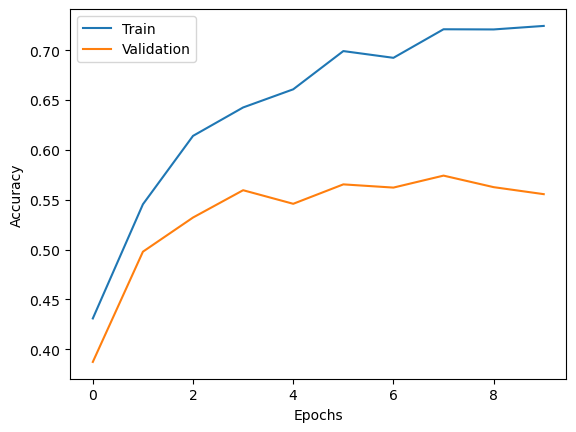

In [14]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label="Train")
    plt.plot(val_accuracies, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(train_accuracies, val_accuracies)

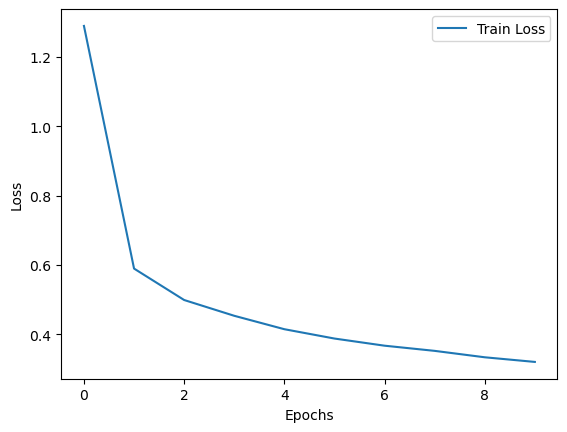

In [15]:
def plot_loss(train_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(train_losses)

In [ ]:
# Store the model and results

import pickle

with open("../models/model_attn.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../models/results_attn.pkl", "wb") as f:
    results = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_accuracy": test_accuracy
    }
    pickle.dump(results, f)

In [ ]:
# Generate predictions

def generate_predictions(lang: str, model: Translator, type: str):
    pairs = get_data(lang, type)
    data = [pair[1] for pair in pairs]
    predictions = [model.evaluate(pair[1]) for pair in pairs]
    return data, predictions

# Store predictions 

def store_predictions(lang: str, model: Translator, type: str):
    data, predictions = generate_predictions(lang, model, type)
    df = pd.DataFrame({'data': data, 'predictions': predictions})
    df.to_csv(f'../predictions/{lang}_{type}_predictions_attn.csv', index=False)

store_predictions(language, model, 'train')
store_predictions(language, model, 'dev')
store_predictions(language, model, 'test')

In [ ]:
# Load the model and results
    
model = None
results = None

with open("../models/model_attn.pkl", "rb") as f:
    model = pickle.load(f)

with open("../models/results_attn.pkl", "rb") as f:
    results = pickle.load(f)

print(results)